In [70]:
#Code door lukas Biesma
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import emcee
import corner

In [71]:
#uitlezen en meuk
filename = "51Peg_mayorqueloz95_alop2025_2026.csv"
data = np.loadtxt(filename, delimiter=',', skiprows=1)
time = data[:, 0]
v_rad = data[:, 1]
sigma = data[:, 2]

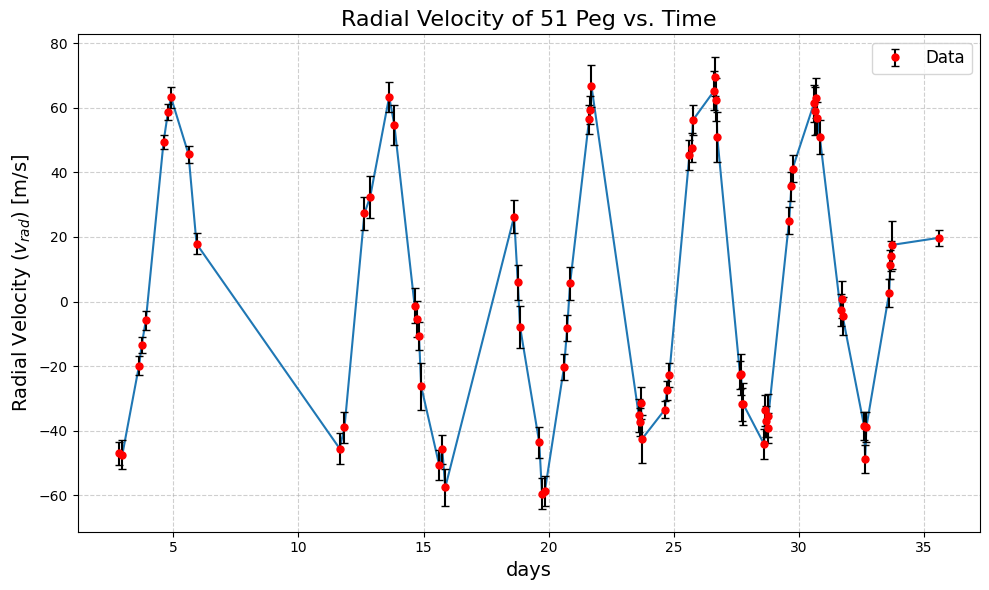

In [72]:
#plotten tegen tijd
plt.figure(figsize=(10, 6))
plt.plot(time, v_rad)
plt.errorbar(time, v_rad, yerr=sigma, fmt='o', color='red', 
                 ecolor='black', capsize=3, markersize=5, label='Data')

plt.xlabel('days', fontsize=14)
plt.ylabel('Radial Velocity ($v_{rad}$) [m/s]', fontsize=14)
plt.title('Radial Velocity of 51 Peg vs. Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)    
plt.legend(fontsize=12)
plt.tight_layout()
# Save at high quality
plt.savefig(
    "radial_velocity_51peg.png",
    dpi=600,              
    bbox_inches="tight",  
    facecolor="white"
)
plt.show()

In [73]:
#estimation from eye: data starts around day 2.8 and the 6th period ends at day 32.6 so I will say a period is about 5 days. P = 5days K about 60 m/s.
P_est = 5.0 #days
K_est = 60.0 #m/s


#We will now use the CHi^2 formula from the problem set to estimate P and K. 
#define the needed chi formula
def get_chi2(params, t, v_obs, sigma):
    """
    Calculates chi-squared for a sinusoidal model.
    Params: (K, P, f0, v0)
    """
    K, P, f0, v0 = params
    
    # Calculate phase f (0 to 1 cycle)
    # Model: v_rad = K * sin(2*pi * (t/P + f0)) + v0
    phase = (t / P) + f0
    model = K * np.sin(2 * np.pi * phase) + v0
    
    residuals = (v_obs - model) / sigma
    return np.sum(residuals**2)

#Ranges specified in the problem
# Period P: Varies ±1 day from eye-estimate, stepsize 0.01
P_values = np.arange(P_est - 1.0, P_est + 1.0, 0.01)
# Amplitude K: Varies ±10 m/s from eye-estimate, stepsize 1
K_values = np.arange(K_est - 10.0, K_est + 11.0, 1.0)

# Phase offset f0: 0 to 1, stepsize 0.01
f0_values = np.arange(0, 1.0, 0.01)

# Center around the mean of the found data, this made the most sense to me
v_mean = np.median(v_rad) 
v0_step = 1.0 # m/s 
v0_values = np.arange(v_mean - 20, v_mean + 20, v0_step) 

# Arrays to store results
min_chi2_per_P = []   # To store the lowest chi2 for each P we loop over
best_params = [] = [] # To store the best K, f0, v0
best_global_chi2 = np.inf #so this exists

total_steps = len(P_values)


print(f"P steps: {len(P_values)}, K steps: {len(K_values)}, "
      f"f0 steps: {len(f0_values)}, v0 steps: {len(v0_values)}")
print(f"Total models to check: {len(P_values)*len(K_values)*len(f0_values)*len(v0_values)}")
print("Damn that many?!")

P steps: 200, K steps: 21, f0 steps: 100, v0 steps: 40
Total models to check: 16800000
Damn that many?!


In [74]:
# Loop over Periods (Outer Loop)
for i, P in enumerate(P_values):
    if i % max(1, int(total_steps/10)) == 0:
        print(f"Processing Period {P:.2f} days ({i}/{total_steps})") #progress to give hope during waiting
    #we add this so it is defined
    current_min_chi2 = np.inf
    #amplitude  
    for K in K_values:
            #velocties
            for v0 in v0_values:
                for f0 in f0_values:
                     # Calculate Chi2
                    current_chi2 = get_chi2((K, P, f0, v0), time, v_rad, sigma)
                
                    # Check if this is the best for this specific Period
                    if current_chi2 < current_min_chi2:
                        current_min_chi2 = current_chi2
                
                    # Check if this is the best so far
                    if current_chi2 < best_global_chi2:
                        best_global_chi2 = current_chi2
                        best_params = [K, P, f0, v0]
            

    # Store the absolute minimum chi2 found for this specific Period P
    min_chi2_per_P.append(current_min_chi2)
print(f"Done")
#printing our findings
print(f"Coarse search done. Best Chi2: {best_global_chi2:.2f}")
print(f"Coarse Params: P={best_params[1]:.3f}, K={best_params[0]}, f0={best_params[2]:.2f}, v0={best_params[3]:.2f}")



Processing Period 4.00 days (0/200)
Processing Period 4.20 days (20/200)
Processing Period 4.40 days (40/200)
Processing Period 4.60 days (60/200)
Processing Period 4.80 days (80/200)
Processing Period 5.00 days (100/200)
Processing Period 5.20 days (120/200)
Processing Period 5.40 days (140/200)
Processing Period 5.60 days (160/200)
Processing Period 5.80 days (180/200)
Done
Coarse search done. Best Chi2: 80.17
Coarse Params: P=4.230, K=57.0, f0=0.05, v0=7.40


In [75]:
#we now look closer at our found values
best_K_coarse, best_P_coarse, best_f0_coarse, best_v0_coarse = best_params

# Define Narrow Ranges
# Period: +/- 0.1 day, step 0.001
P_fine = np.arange(best_P_coarse - 0.1, best_P_coarse + 0.1, 0.001)

# Amplitude: +/- 2 m/s, step 0.5
K_fine = np.arange(best_K_coarse - 2.0, best_K_coarse + 2.0, 0.05)

# Phase: +/- 0.05, step 0.005
f0_fine = np.arange(best_f0_coarse - 0.05, best_f0_coarse + 0.05, 0.005)

# Velocity: +/- 2 m/s, step 0.5
v0_fine = np.arange(best_v0_coarse - 2.0, best_v0_coarse + 2.0, 0.5)

# Reset global best tracker for the fine search
final_best_chi2 = np.inf
final_best_params = []


print(f"P steps: {len(P_fine)}, K steps: {len(K_fine)}, "
      f"f0 steps: {len(f0_fine)}, v0 steps: {len(v0_fine)}")
print(f"Total models to check: {len(P_fine)*len(K_fine)*len(f0_fine)*len(v0_fine)}")
print("Damn that many?!")


total_fine = len(P_fine)

for i, P in enumerate(P_fine):
    if i % max(1, int(total_fine/5)) == 0:
        print(f"Refining P = {P:.4f}...")

    for K in K_fine:
        for v0 in v0_fine:
            for f0 in f0_fine:
                
                chi2 = get_chi2((K, P, f0, v0), time, v_rad, sigma)
                
                if chi2 < final_best_chi2:
                    final_best_chi2 = chi2
                    final_best_params = [K, P, f0, v0]

K_final, P_final, f0_final, v0_final = final_best_params

print("FINAL BEST FIT RESULTS")
print(f"Period (P)    : {P_final:.10f} days")
print(f"Amplitude (K) : {K_final:.10f} m/s")
print(f"Phase (f0)    : {f0_final:.10f}")
print(f"Velocity (v0) : {v0_final:.10f} m/s")
print(f"Minimum Chi2  : {final_best_chi2:.10f}")

P steps: 200, K steps: 80, f0 steps: 20, v0 steps: 8
Total models to check: 2560000
Damn that many?!
Refining P = 4.1300...
Refining P = 4.1700...
Refining P = 4.2100...
Refining P = 4.2500...
Refining P = 4.2900...
FINAL BEST FIT RESULTS
Period (P)    : 4.2320000000 days
Amplitude (K) : 56.6000000000 m/s
Phase (f0)    : 0.0550000000
Velocity (v0) : 7.4010000000 m/s
Minimum Chi2  : 76.7653541430


In [76]:
P_final_typ = 4.232
K_final_typ = 56.65
f0_final_typ = 0.055
v0_final_typ = 7.7934844156
final_best_chi2_typ = 76.7178586009




#now mass calculation timeee
# Constants
G = 6.67430e-11       # m^3 kg^-1 s^-2
M_jup_kg = 1.898e27   # kg
M_sun_kg = 1.989e30   # kg

# Star Mass
M_star = 1.11 * M_sun_kg 

# Convert period to seconds
P_sec = P_final * 86400

# Formula from problem set
term1 = K_final
term2 = M_star**(2/3)
term3 = (P_sec / (2 * np.pi * G))**(1/3)

Mp_sini_kg = term1 * term2 * term3
Mp_sini_jup = Mp_sini_kg / M_jup_kg

print(f"Minimal Mass (Mp sin i): {Mp_sini_jup:.3f} Jupiter Masses")


Minimal Mass (Mp sin i): 0.483 Jupiter Masses


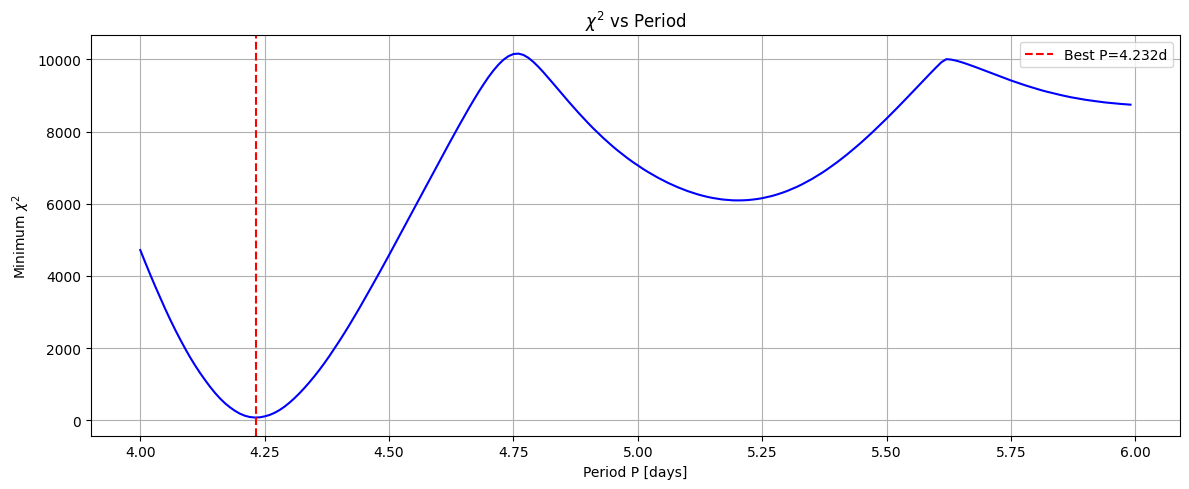

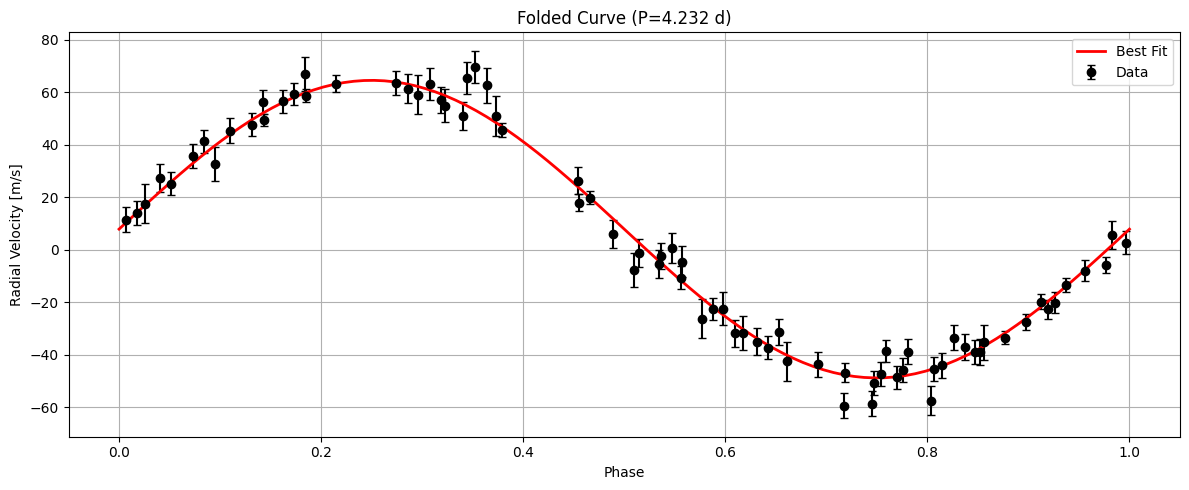

In [77]:
#Chi2 vs Period 
plt.figure(figsize=(12, 5))

plt.plot(P_values, min_chi2_per_P, 'b-')
plt.axvline(P_final_typ, color='r', linestyle='--', label=f'Best P={P_final:.3f}d')
plt.xlabel('Period P [days]')
plt.ylabel(r'Minimum $\chi^2$')
plt.title(r'$\chi^2$ vs Period')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "chi2 vs period.png",
    dpi=600,              
    bbox_inches="tight",  
    facecolor="white"
)
plt.show()



# Calculate phase for data
phase_obs = ((time / P_final_typ) + f0_final_typ) % 1

# Create smooth model for plotting
phase_model = np.linspace(0, 1, 100)
v_model = K_final_typ * np.sin(2 * np.pi * phase_model) + v0_final_typ

# Plot
plt.figure(figsize=(12, 5))
plt.errorbar(phase_obs, v_rad, yerr=sigma, fmt='ko', capsize=3, label='Data')
plt.plot(phase_model, v_model, 'r-', linewidth=2, label='Best Fit')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity [m/s]')
plt.title(f'Folded Curve (P={P_final:.3f} d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "speed vs phase.png",
    dpi=600,              
    bbox_inches="tight",  
    facecolor="white"
)
plt.show()








In [78]:
P_final_typ = 4.232
K_final_typ = 56.65
f0_final_typ = 0.055
v0_final_typ = 7.7934844156
final_best_chi2_typ = 76.7178586009


#Problem 3
#determine degrees of freedom
#n = N-m with N number of data and m parameters
N = len(time)
m = 4
n = N - m

print(f"degrees of freedom = {n}")

#we now calculate the chi^2 limit
#we use percent point function ppf which is the inverse of CDF
chi2_lim = stats.chi2.ppf(1 - 0.05, n)

print(f"Chi-squared limit (chi2_lim) for n={n}: {chi2_lim:.4f}")
print(f"Minimum Chi2  : {final_best_chi2_typ:.10f}")



print("CONCLUSION: ACCEPT the hypothesis.")
print("The chi-squared value is below the limit. The model provides a statistically")
print("acceptable fit to the observations (at the 95% confidence level).")


degrees of freedom = 73
Chi-squared limit (chi2_lim) for n=73: 93.9453
Minimum Chi2  : 76.7178586009
CONCLUSION: ACCEPT the hypothesis.
The chi-squared value is below the limit. The model provides a statistically
acceptable fit to the observations (at the 95% confidence level).


You must install the tqdm library to use progress indicators with emcee



--- Starting MCMC Run ---


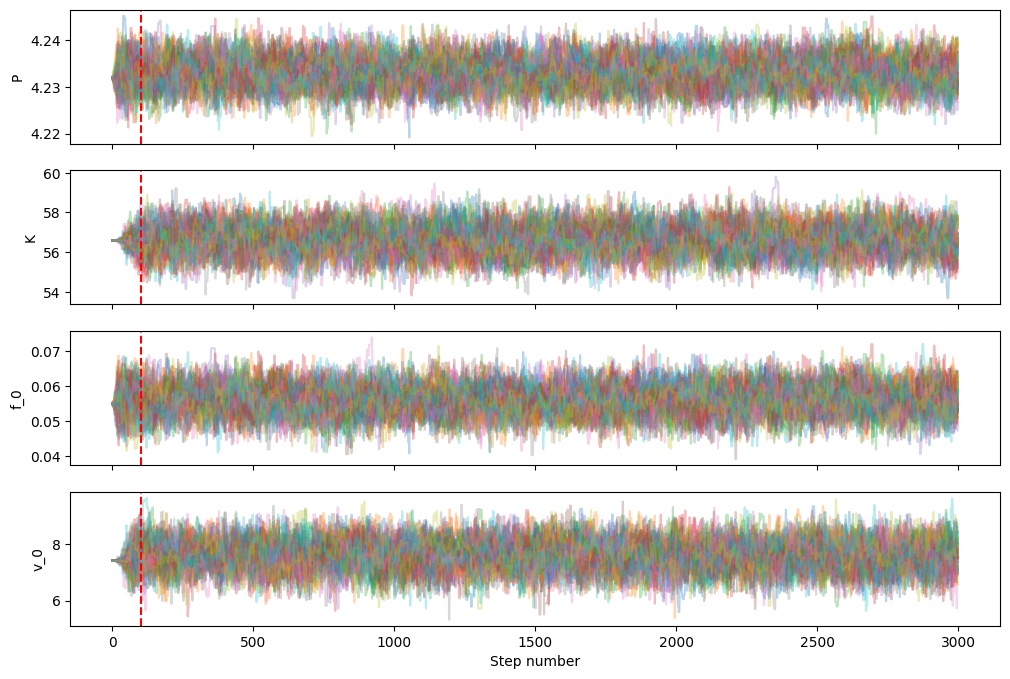

Total samples kept: 145000


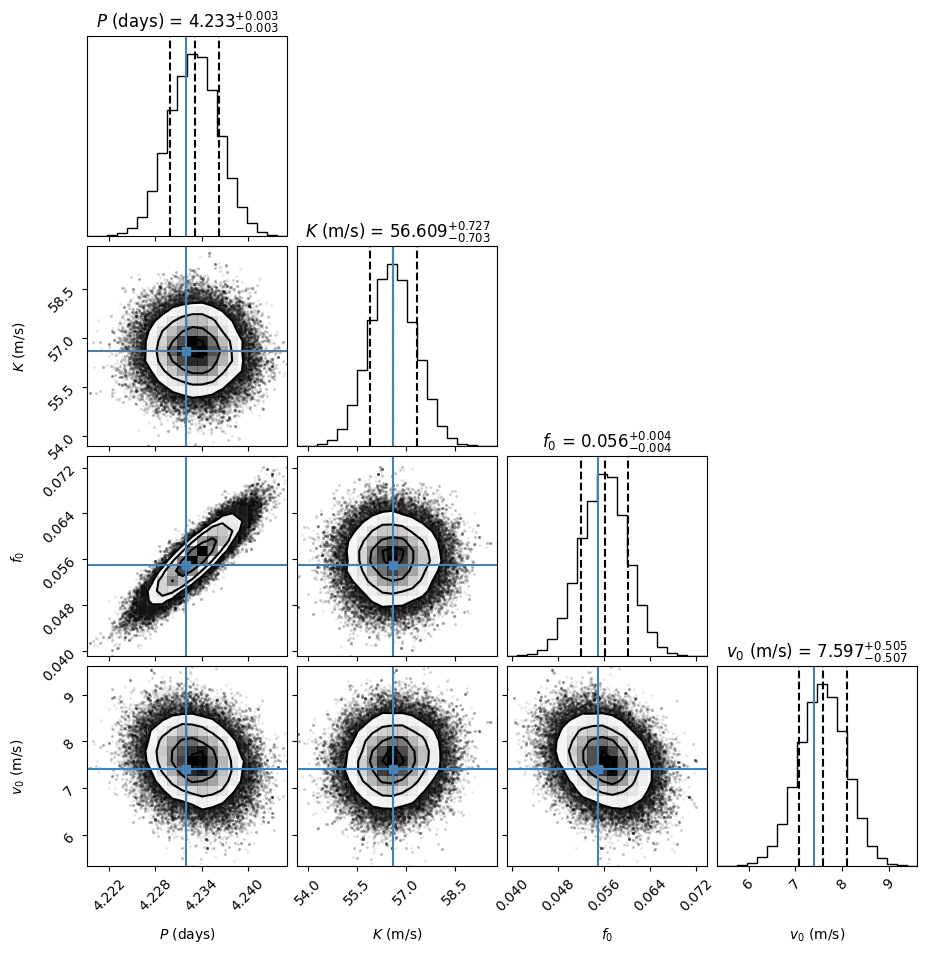

In [79]:
#problem 4
#define our expected values from before
theta_hat = np.array([P_final, K_final, f0_final, v0_final])

#Define Priors 
# We need to choose the width (sigma) for the prior on each parameter.
# These widths reflect our prior belief or allow the walker to explore around the guess.
# - P: +/- 0.1 days According to previous research we are already very close to the period found in that study so this can be small
# - K: +/- 20 m/s 
# - f0: +/- 0.5 Phase is 0-1, so this covers the whole range
# - v0: +/- 10 m/s Systemic velocity width

sigma_prior = np.array([0.1, 20.0, 0.5, 10.0]) 

def ln_prior(theta):
    """
    Gaussian Prior (Equation 9).
    Returns sum of log-probs for each parameter.
    """
    P, K, f0, v0 = theta
        
    # Gaussian Prior Calculation: Sum of -0.5 * ((val - guess)/sigma)^2
    # We ignore the constant normalization term (1/sqrt(2pi...)) as it cancels out in MCMC
    log_prior_val = -0.5 * np.sum(((theta - theta_hat) / sigma_prior)**2)
    
    return log_prior_val

# 2. Define Likelihood (Eq 3 & 4 related)
def ln_likelihood(theta, t, y, yerr):
    """
    Log-Likelihood Function.
    ln L = -0.5 * chi^2
    """
    P, K, f0, v0 = theta
    
    # Model: v = K * sin(2*pi*(t/P + f0)) + v0
    phase = (t / P) + f0
    model = K * np.sin(2 * np.pi * phase) + v0
    
    # Chi-squared
    chi2 = np.sum(((y - model) / yerr)**2)
    
    return -0.5 * chi2

# 3. Define Probability (Posterior)
def ln_probability(theta, t, y, yerr):
    """
    Posterior function for emcee.
    ln P(theta|data) ~ ln L + ln Prior
    """
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, t, y, yerr)

# ==========================================
# RUN MCMC (emcee)
# ==========================================
print("\n--- Starting MCMC Run ---")

# Setup MCMC properties
ndim = 4        # Number of parameters [K, P, f0, v0]
nwalkers = 50   # Number of walkers (Problem: "Decide on number")
nsteps = 3000   # Steps per walker (Running longer ensures better sampling)

# Initialize walkers
# We start them in a "tiny ball" around our best fit to give them a good starting point
pos = theta_hat + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the Sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(time, v_rad, sigma))

# Run the MCMC
sampler.run_mcmc(pos, nsteps, progress=True)

#to see what we burn:
# First we get the full chain
chain = sampler.get_chain()

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.set_size_inches(12, 8)

# Period P
axes[0].plot(chain[:, :, 0], alpha = 0.3)
axes[0].set_ylabel("P")
axes[0].axvline(100, ls = "--", color = "red")

# Amplitude K
axes[1].plot(chain[:, :, 1], alpha = 0.3)
axes[1].set_ylabel("K")
axes[1].axvline(100, ls = "--", color = "red")

# Phase offset f_0
axes[2].plot(chain[:, :, 2], alpha = 0.3)
axes[2].set_ylabel("f_0")
axes[2].axvline(100, ls = "--", color = "red")

# Systemic velocity v_0
axes[3].plot(chain[:, :, 3], alpha = 0.3)
axes[3].set_ylabel("v_0")
axes[3].axvline(100, ls = "--", color = "red")

axes[3].set_xlabel("Step number")
plt.savefig(
    "burnindicator.png",
    dpi=600,              
    bbox_inches="tight",  
    facecolor="white"
)
plt.show()

# 1. Discard Burn-in
# The "burn-in" is the initial phase where walkers find the equilibrium. 
# We discard the first ~100 steps.
burnin = 100
flat_samples = sampler.get_chain(discard=burnin, flat=True)

print(f"Total samples kept: {flat_samples.shape[0]}")

# 2. Generate Corner Plot (Problem 4 Requirement)
labels = [r"$P$ (days)", r"$K$ (m/s)", r"$f_0$", r"$v_0$ (m/s)"]

# Corner plot showing histograms and 2D correlations
fig = corner.corner(
    flat_samples, 
    labels=labels,
    truths=theta_hat,            # Shows your starting guess (blue lines)
    quantiles=[0.160, 0.50, 0.840], # Shows 1-sigma confidence intervals
    show_titles=True,            # Prints the values + errors on top
    title_kwargs={"fontsize": 12},
    title_fmt=".3f"
)
plt.savefig(
    "cornerplot.png",
    dpi=600,              
    bbox_inches="tight",  
    facecolor="white"
)
plt.show()



In [80]:
#problem 5

# Print Parameter Uncertainties
for i, name in enumerate(labels):
    mcmc_val = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc_val) # q[0] is lower error, q[1] is upper error
    print(f"{name}: {mcmc_val[1]:.4f} (+{q[1]:.4f} / -{q[0]:.4f})")

# Calculate Mass Uncertainty

# Constants
G = 6.67430e-11
M_star = 1.11 * 1.989e30 # Solar Mass (kg)
M_jup = 1.898e27         # Jupiter Mass (kg)

# Extract chains for K and P
chain_K = flat_samples[:, 1]
chain_P = flat_samples[:, 0] * 86400 # Convert days to seconds

# Calculate Mass array (Mp sin i)
mass_chain_kg = chain_K * (M_star**(2/3)) * ((chain_P / (2 * np.pi * G))**(1/3))
mass_chain_jup = mass_chain_kg / M_jup

# Get percentiles for Mass
mass_mcmc = np.percentile(mass_chain_jup, [16, 50, 84])
mass_err = np.diff(mass_mcmc)

print("-" * 30)
print(f"Minimal Mass (Mp sin i):")
print(f"{mass_mcmc[1]:.3f} +{mass_err[1]:.3f} / -{mass_err[0]:.3f} Jupiter Masses")
print("-" * 30)



$P$ (days): 4.2331 (+0.0032 / -0.0032)
$K$ (m/s): 56.6085 (+0.7268 / -0.7031)
$f_0$: 0.0561 (+0.0040 / -0.0041)
$v_0$ (m/s): 7.5968 (+0.5047 / -0.5069)
------------------------------
Minimal Mass (Mp sin i):
0.483 +0.006 / -0.006 Jupiter Masses
------------------------------
